In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
train_file_path = "/content/arHateDataset.csv"
test_file_path = "/content/OSACT2020-sharedTask-train.txt"

In [9]:
!ls 'OSACT2020-sharedTask-train.txt'

OSACT2020-sharedTask-train.txt


In [10]:
!ls 'arHateDataset.csv'

arHateDataset.csv


In [11]:
import re
import string
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, roc_curve, classification_report

In [12]:
df_train  = pd.read_csv(test_file_path,sep="\t",header=None)
df_train.columns =  ["Tweet","Offensive","Hate"]

In [13]:
df_train

,Tweet,Offensive,Hate
0,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,NOT_OFF,NOT_HS
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT_OFF,NOT_HS
2,RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ا...,OFF,HS
3,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,NOT_OFF,NOT_HS
4,يا بكون بحياتك الأهم يا إما ما بدي أكون 🎼,NOT_OFF,NOT_HS
...,...,...,...
6834,@USER يا حمار ، يا جاهل ، نسبة الباطل ما بتتحس...,OFF,NOT_HS
6835,RT @USER: @USER كل زق يا طاقية يا واطي يا حقير...,OFF,NOT_HS
6836,@USER<LF>يا كبير يا ممتع يا نجم لابد أن تعي جي...,NOT_OFF,NOT_HS
6837,يا رب الاتحاد يفوز يا رب. 😭😭 #الاتحاد_النصر,NOT_OFF,NOT_HS


In [14]:
df_dev  = pd.read_csv(test_file_path,sep="\t",header=None)
df_dev.columns =  ["Tweet","Offensive","Hate"]

In [15]:
df_dev

,Tweet,Offensive,Hate
0,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,NOT_OFF,NOT_HS
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT_OFF,NOT_HS
2,RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ا...,OFF,HS
3,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,NOT_OFF,NOT_HS
4,يا بكون بحياتك الأهم يا إما ما بدي أكون 🎼,NOT_OFF,NOT_HS
...,...,...,...
6834,@USER يا حمار ، يا جاهل ، نسبة الباطل ما بتتحس...,OFF,NOT_HS
6835,RT @USER: @USER كل زق يا طاقية يا واطي يا حقير...,OFF,NOT_HS
6836,@USER<LF>يا كبير يا ممتع يا نجم لابد أن تعي جي...,NOT_OFF,NOT_HS
6837,يا رب الاتحاد يفوز يا رب. 😭😭 #الاتحاد_النصر,NOT_OFF,NOT_HS


In [16]:
df_train['Hate'].value_counts()

NOT_HS    6489
HS         350
Name: Hate, dtype: int64

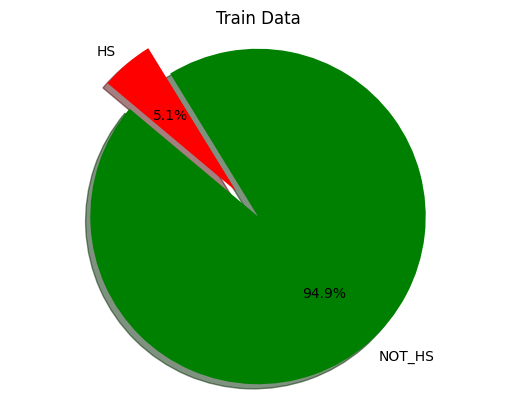

In [17]:
# Data to plot
labels = 'NOT_HS', 'HS'
sizes = [df_train['Hate'].value_counts()[0], df_train['Hate'].value_counts()[1]]
colors = ['green', 'red']
explode = (0,0.2)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("Train Data")
plt.show()

In [18]:
df_dev['Hate'].value_counts()

NOT_HS    6489
HS         350
Name: Hate, dtype: int64

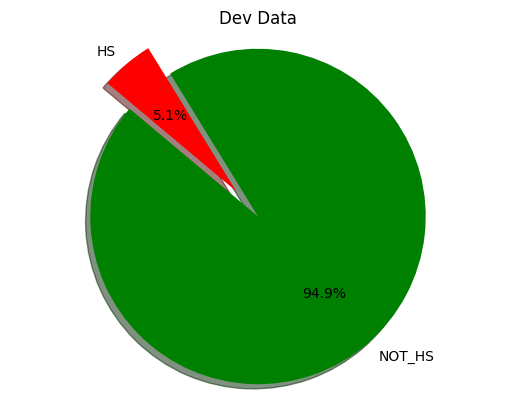

In [19]:
# Data to plot
labels = 'NOT_HS', 'HS'
sizes = [df_dev['Hate'].value_counts()[0], df_dev['Hate'].value_counts()[1]]
colors = ['green', 'red']
explode = (0,0.2)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("Dev Data")
plt.show()

In [20]:
def clean(df):
    df = remove_diacritics(df)
    df = remove_punctuations(df)
    df = remove_repeating_char(df)
    df = normalize_arabic(df)
    df = remove_english_word_and_numbers(df)
    df = clean_space(df)
    return df

In [21]:
arabic_punctuations = '''`÷« »×؛<>٩٨'٧٦٥٤٣٢١٠_()↗*•&^%][ـ،/:"؟.,'{}⋮≈~¦+|٪!”…“–ـ/[]%=#*+\\•~@£·_{}©^®`→°€™›♥←×§″′Â█à…“★”–●â►−¢¬░¶↑±▾	═¦║―¥▓—‹─▒：⊕▼▪†■’▀¨▄♫☆é¯♦¤▲è¸Ã⋅‘∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤ïØ¹≤‡₹´'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

In [22]:
def remove_diacritics(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_diacritics(x))
    return df
def _remove_diacritics(x):
    x = str(x)
    x = re.sub(arabic_diacritics, '', x)
    return x

def normalize_arabic(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _normalize_arabic(x))
    return df
def _normalize_arabic(x):
    x = str(x)
    # added space around puncts after replace
    x = re.sub("[إأآا]", "ا", x)
    x = re.sub("ى", "ي", x)
    x = re.sub("ؤ", "ء", x)
    x = re.sub("ئ", "ء", x)
    x = re.sub("ة", "ه", x)
    x = re.sub("گ", "ك", x)
    return x


In [23]:
def remove_punctuations(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_punctuations(x))
    return df

In [24]:
def _remove_punctuations(x):
    x = str(x)
    #translator = str.maketrans(' ', ' ', punctuations_list)
    translator = str.maketrans(punctuations_list, ' '*len(punctuations_list))
    return x.translate(translator)


In [25]:
def remove_repeating_char(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_repeating_char(x))
    return df

In [26]:
def _remove_repeating_char(x):
    x = str(x)
    return re.sub(r'(.)\1+', r'\1', x)


In [27]:
def remove_english_word_and_numbers(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: _remove_english_word_and_numbers(x))
    return df

In [28]:
def _remove_english_word_and_numbers(x):
    x = str(x)
    return re.sub(r'[a-zA-Z0-9]+', '', x)

In [29]:
def clean_space(df):
    compiled_re = re.compile(r"\s+")
    df['Tweet'] = df["Tweet"].apply(lambda x: _clean_space(x, compiled_re))
    return df

In [30]:
def _clean_space(x, compiled_re):
    return compiled_re.sub(" ", x)


In [31]:
import nltk
from nltk.stem.isri import ISRIStemmer
def stemming(df):
  tweets = []
  for tweet in df['Tweet']:
    tokenization = nltk.word_tokenize(tweet)
    stemming = []
    st = ISRIStemmer()
    for word in tokenization:
        stemming.append(st.stem(word))
    tweets.append(" ".join(stemming))
  return tweets

In [32]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [33]:
#dd = stemming(data)

In [34]:
train_data = pd.DataFrame(clean(df_train))

In [35]:
train_data

,Tweet,Offensive,Hate
0,الحمدله يارب فوز مهم يا زمالك كل الدعم ليكم يا...,NOT_OFF,NOT_HS
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT_OFF,NOT_HS
2,يا رب يا واحد يا احد بحق يوم الاحد ان تهلك بن...,OFF,HS
3,هوا الحريه يا وجع قلبي عليكي يا امي اله لا يح...,NOT_OFF,NOT_HS
4,يا بكون بحياتك الاهم يا اما ما بدي اكون 🎼,NOT_OFF,NOT_HS
...,...,...,...
6834,يا حمار يا جاهل نسبه الباطل ما بتحسبش و عاملي...,OFF,NOT_HS
6835,كل زق يا طاقيه يا واطي يا حقير يا تافه يا ساف...,OFF,NOT_HS
6836,يا كبير يا متع يا نجم لابد ان تعي جيدا انا ما...,NOT_OFF,NOT_HS
6837,يا رب الاتحاد يفوز يا رب 😭 الاتحاد النصر,NOT_OFF,NOT_HS


In [36]:
test_data = pd.DataFrame(clean(df_dev))

In [37]:
test_data

,Tweet,Offensive,Hate
0,الحمدله يارب فوز مهم يا زمالك كل الدعم ليكم يا...,NOT_OFF,NOT_HS
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT_OFF,NOT_HS
2,يا رب يا واحد يا احد بحق يوم الاحد ان تهلك بن...,OFF,HS
3,هوا الحريه يا وجع قلبي عليكي يا امي اله لا يح...,NOT_OFF,NOT_HS
4,يا بكون بحياتك الاهم يا اما ما بدي اكون 🎼,NOT_OFF,NOT_HS
...,...,...,...
6834,يا حمار يا جاهل نسبه الباطل ما بتحسبش و عاملي...,OFF,NOT_HS
6835,كل زق يا طاقيه يا واطي يا حقير يا تافه يا ساف...,OFF,NOT_HS
6836,يا كبير يا متع يا نجم لابد ان تعي جيدا انا ما...,NOT_OFF,NOT_HS
6837,يا رب الاتحاد يفوز يا رب 😭 الاتحاد النصر,NOT_OFF,NOT_HS


In [38]:
x_train=train_data.iloc[:,0]
y_train=train_data.iloc[:,2]

label_mapping = {'HS': 1, 'NOT_HS': 0}

# Convert training labels
y_train = y_train.map(label_mapping)

In [39]:
# Vectorize training data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

In [40]:
target_class = 0
oversampling_ratio = {target_class: 3645}
ros = RandomUnderSampler(sampling_strategy=oversampling_ratio, random_state=42)
x_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)

labels_hate = y_resampled.values
class_names = np.unique(labels_hate)
class_weights = compute_class_weight(class_weight = "balanced", classes = class_names, y = labels_hate)

In [41]:
print(y_resampled.value_counts())

0    3645
1     350
Name: Hate, dtype: int64


In [42]:
class_weights = dict(zip(np.unique(labels_hate), class_weights))
print(class_weights)

{0: 0.5480109739368999, 1: 5.707142857142857}


In [43]:
# Train SVM classifier with class weights
clf = SVC(random_state=0, class_weight={class_names[0]: class_weights[0], class_names[1]: class_weights[1]})
clf.fit(x_resampled, y_resampled)

SVC(class_weight={0: 0.5480109739368999, 1: 5.707142857142857}, random_state=0)

In [44]:
x_test=test_data.iloc[:,0]
y_test=test_data.iloc[:,2]

label_mapping = {'HS': 1, 'NOT_HS': 0}

y_test = y_test.map(label_mapping)

In [45]:
# Vectorize test data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(x_test)

In [46]:
# Make predictions
y_pred = clf.predict(X_test_tfidf)

In [47]:
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6489
           1       0.99      1.00      0.99       350

    accuracy                           1.00      6839
   macro avg       0.99      1.00      1.00      6839
weighted avg       1.00      1.00      1.00      6839




Macro F1: 99.70%
Accuracy: 99.94%
Macro Precision: 99.44%
Macro Recall: 99.97%


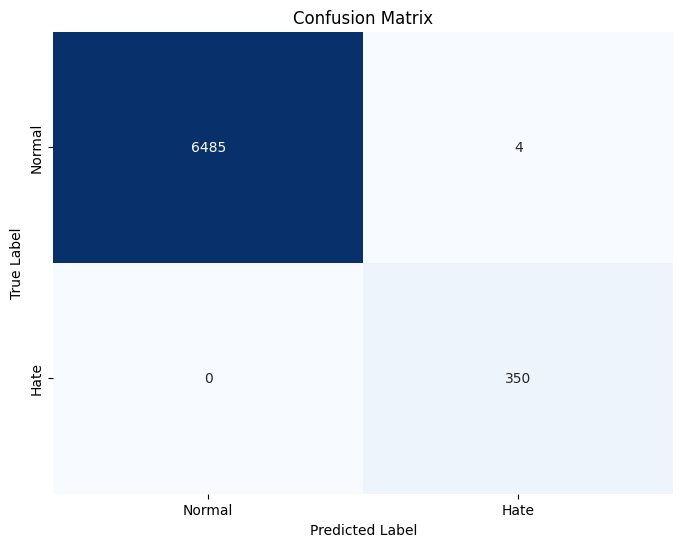

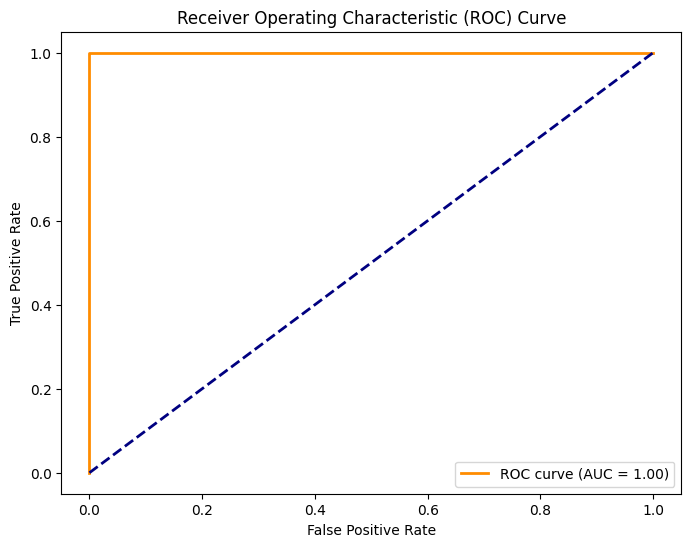

In [48]:

macro_f1 = f1_score(y_test, y_pred,average='macro')
macro_precision = precision_score(y_test, y_pred,average='macro')
macro_recall = recall_score(y_test, y_pred,average='macro')
acc = accuracy_score(y_test, y_pred)

print(f"\nMacro F1: {macro_f1 * 100:.2f}%")
print(f"Accuracy: {acc * 100:.2f}%")
print(f"Macro Precision: {macro_precision * 100:.2f}%")
print(f"Macro Recall: {macro_recall * 100:.2f}%")

# Output the confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Hate'], yticklabels=['Normal', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Predicted probabilities
y_pred_proba = clf.decision_function(X_test_tfidf)

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Logistisc regression classifier


In [49]:
from sklearn import linear_model

In [50]:
LR= linear_model.LogisticRegression()
LR.fit(X_train_tfidf, y_pred)
LR.score(X_train_tfidf,y_pred)

0.9483842667056587

In [51]:
x_pred=test_data.iloc[:,0]
y_test=test_data.iloc[:,2]
X=x_test.to_dict()

X=[]
for d in range(len(X)):
    b=X[d].lower()
    X.append(b)
    y_test_tfidf=count_vect.transform(x_test)
    y_pred=LR.predict(X_test_tfidf)

In [52]:
from sklearn.metrics import classification_report as creport


In [53]:
# Assuming X_test and y_pred are defined elsewhere in the code
print(creport(y_train, y_pred,target_names=['HS', 'NOT_HS'],digits=4))

              precision    recall  f1-score   support

          HS     1.0000    0.9994    0.9997      6489
      NOT_HS     0.9887    1.0000    0.9943       350

    accuracy                         0.9994      6839
   macro avg     0.9944    0.9997    0.9970      6839
weighted avg     0.9994    0.9994    0.9994      6839



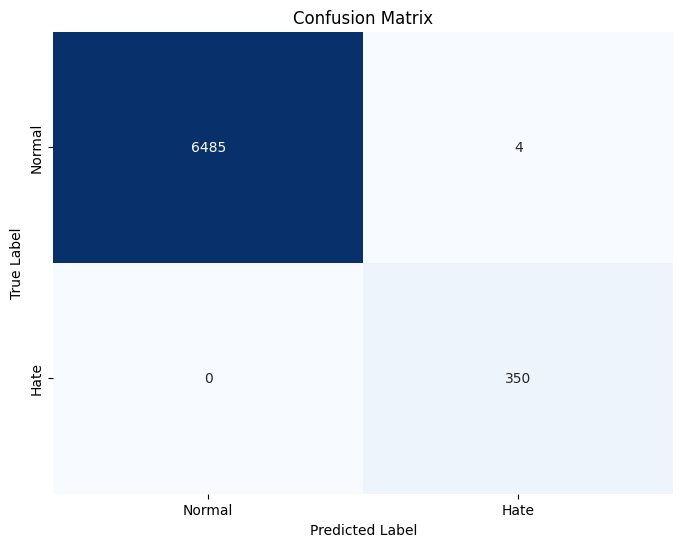

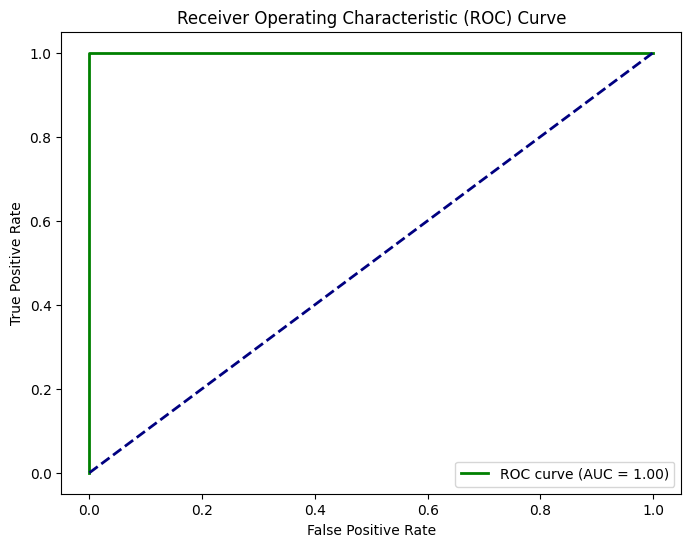

In [54]:
# Output the confusion matrix
conf_matrix = metrics.confusion_matrix(y_train, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Hate'], yticklabels=['Normal', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Predicted probabilities
y_pred_proba = clf.decision_function(X_train_tfidf)

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_train, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Random Forest Classifier


In [55]:
from sklearn import model_selection, naive_bayes, svm, ensemble, tree
from xgboost import XGBClassifier

In [56]:
RF= ensemble.RandomForestClassifier()
RF.fit(X_train_tfidf,y_pred)
RF.score(X_train_tfidf,y_pred)

1.0

In [57]:
x_pred=test_data.iloc[:,0]
y_test=test_data.iloc[:,2]
X=x_test.to_dict()

X=[]
for d in range(len(X)):
    b=X[d].lower()
    X.append(b)
    y_test_tfidf=count_vect.transform(x_test)
    y_pred=LR.predict(X_test_tfidf)

In [58]:
print(creport(y_train, y_pred,target_names=['HS', 'NOT_HS'] ,digits=4))

              precision    recall  f1-score   support

          HS     1.0000    0.9994    0.9997      6489
      NOT_HS     0.9887    1.0000    0.9943       350

    accuracy                         0.9994      6839
   macro avg     0.9944    0.9997    0.9970      6839
weighted avg     0.9994    0.9994    0.9994      6839





```
```

*naive* bayes
##(MultinomialNB)


In [75]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
data = pd.read_csv('arHateDataset.csv')

In [78]:
data

,Tweet,Class
0,تعلن #وزارة_الصحة عن وفاة مقيم مصاب بمرض كورون...,0
1,خايفة يجيبوا لقاح الكورونا وما يكفينا ، يقوموا...,0
2,رسمياً.. #الرئاسة_الجزائرية تؤكد إصابة الرئيس ...,0
3,تخيل تجيلك كورونا قبل ما تتزوج تبقي مأساة،\nبع...,0
4,مصير الجزائر والجزائريين معلق بمصير اخواننا وا...,0
...,...,...
33735,@user يا اصحاب بول البعير ومملكة الظلام وقائدك...,1
33736,@user يمشي بخطا ادارتها قيد من الأمريكان ونهب ...,1
33737,@user مهما حصل هندوس عليهم شويه الرويبضه بس نخ...,1
33738,الكلب لا يعض اذن اخوه كذابين خنازير @url,1


In [79]:
data = clean(data)

In [80]:
data

,Tweet,Class
0,تعلن وزاره الصحه عن وفاه مقيم مصاب بمرض كورونا...,0
1,خايفه يجيبوا لقاح الكورونا وما يكفينا يقوموا ي...,0
2,رسميا الرءاسه الجزاءريه تءكد اصابه الرءيس تبون...,0
3,تخيل تجيلك كورونا قبل ما تزوج تبقي ماساه بعد ا...,0
4,مصير الجزاءر والجزاءرين معلق بمصير اخوانا واهل...,0
...,...,...
33735,يا اصحاب بول البعير وملكه الظلام وقاءدكم سلما...,1
33736,يمشي بخطا ادارتها قيد من الامريكان ونهب اسراء...,1
33737,مهما حصل هندوس عليهم شويه الرويبضه بس نخلص ال...,1
33738,الكلب لا يعض اذن اخوه كذابين خنازير,1


In [81]:
data['Class'].value_counts()

0    22789
1    10951
Name: Class, dtype: int64

In [82]:
x= data['Tweet']
y=data['Class']

In [83]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


Macro F1: 85.03%
Accuracy: 86.48%
Macro Precision: 84.37%
Macro Recall: 85.91%


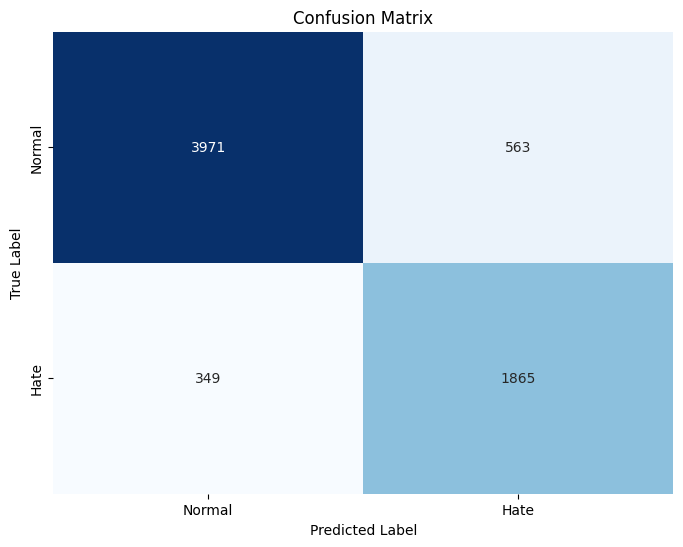

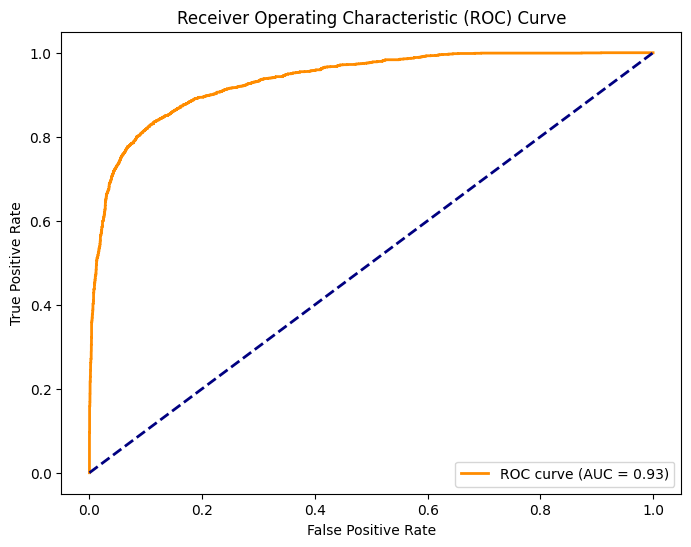

In [91]:
macro_f1 = f1_score(y_test, y_pred,average='macro')
macro_precision = precision_score(y_test, y_pred,average='macro')
macro_recall = recall_score(y_test, y_pred,average='macro')
acc = accuracy_score(y_test, y_pred)

print(f"\nMacro F1: {macro_f1 * 100:.2f}%")
print(f"Accuracy: {acc * 100:.2f}%")
print(f"Macro Precision: {macro_precision * 100:.2f}%")
print(f"Macro Recall: {macro_recall * 100:.2f}%")

# Output the confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Hate'], yticklabels=['Normal', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
# Predicted probabilities
y_pred_proba = model.predict_proba(X_test_tfidf)

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


##BernoulliNB



In [92]:
from sklearn.feature_extraction.text import CountVectorizer

In [93]:
#tfidf_vectorizer = TfidfVectorizer(ngram_range=(3, 3))
#tfidf_vectorizer = CountVectorizer(ngram_range=(3, 3))
tfidf_vectorizer = TfidfVectorizer(min_df=0.0001, max_df=0.95)
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [94]:
# Create the Naive Bayes model
#model = MultinomialNB()
model = BernoulliNB()

In [95]:
# Train the model (reshape text data for MultinomialNB)
model.fit(X_train_tfidf, y_train)

BernoulliNB()

In [96]:
# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)


Macro F1: 85.03%
Accuracy: 86.48%
Macro Precision: 84.37%
Macro Recall: 85.91%


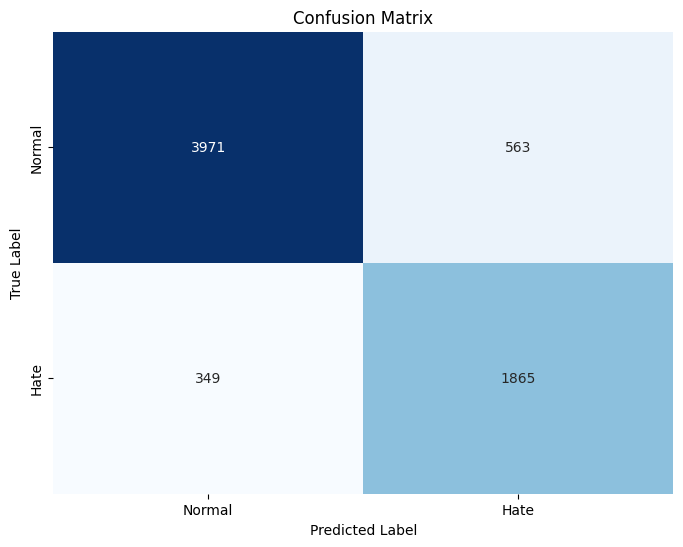

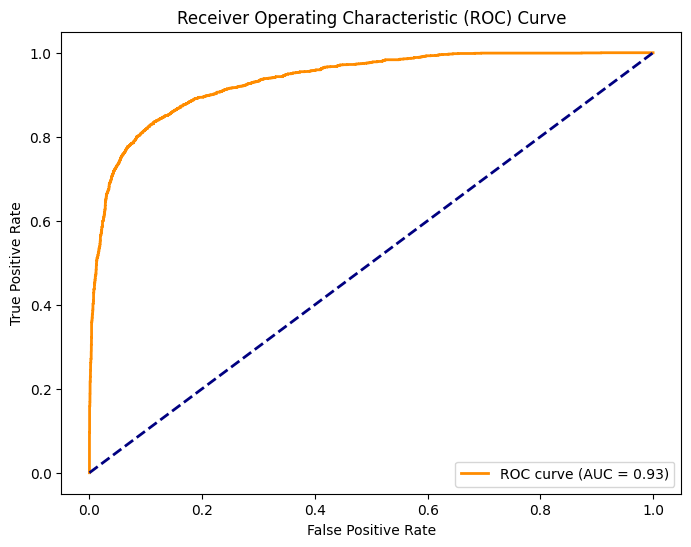

In [97]:
macro_f1 = f1_score(y_test, y_pred,average='macro')
macro_precision = precision_score(y_test, y_pred,average='macro')
macro_recall = recall_score(y_test, y_pred,average='macro')
acc = accuracy_score(y_test, y_pred)

print(f"\nMacro F1: {macro_f1 * 100:.2f}%")
print(f"Accuracy: {acc * 100:.2f}%")
print(f"Macro Precision: {macro_precision * 100:.2f}%")
print(f"Macro Recall: {macro_recall * 100:.2f}%")

# Output the confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Hate'], yticklabels=['Normal', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
# Predicted probabilities
y_pred_proba = model.predict_proba(X_test_tfidf)

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()